In [ ]:
    from google.colab import drive

drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile

file_path = '/content/gdrive/MyDrive/images.zip'
with ZipFile(file_path, 'r') as zip:
    zip.extractall()

print("Done unzipping")

Done unzipping


In [ ]:
!pip install torch
!pip install Cython

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# Data Preprocessing

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel
from PIL import Image
import os

# Paths to images and captions
data_path = '/content/images/Images'
caption_path = '/content/images/captions.txt'

# Read captions file and store captions in a dictionary
def _load_captions(caption_path):
    caption_dict = {}
    with open(caption_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            img_name, caption = line.strip().split(',', 1)
            if img_name in caption_dict:
                caption_dict[img_name].append(caption)
            else:
                caption_dict[img_name] = [caption]
    return caption_dict

caption_dict = _load_captions(caption_path)

# Custom Dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, data_path, caption_dict, transform=None, tokenizer=None):
        self.data_path = data_path
        self.caption_dict = caption_dict
        self.transform = transform
        self.tokenizer = tokenizer
        self.image_files = [f for f in os.listdir(data_path) if f in caption_dict]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.data_path, image_file)
        image = Image.open(image_path).convert("RGB")
        caption = self.caption_dict[image_file][0]
        if self.transform:
            image = self.transform(image)
        if self.tokenizer:
            caption = self.tokenizer(caption, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
            input_ids = caption['input_ids'].squeeze(0)  # shape: [seq_length]
            attention_mask = caption['attention_mask'].squeeze(0)  # shape: [seq_length]
            return image, input_ids, attention_mask


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = ImageCaptionDataset(data_path, caption_dict, transform=transform, tokenizer=tokenizer)

# Split dataset into train, validation, and test sets
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    return random_split(dataset, [train_size, val_size, test_size])

train_dataset, val_dataset, test_dataset = split_dataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# DGAN Model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertModel
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.empty_cache()

# Assuming split_dataset function exists and is implemented correctly
train_dataset, val_dataset, test_dataset = split_dataset(dataset)
batch_size = 128

# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
nc = 3
nz = 100
ngf = 64
ndf = 64
z_dim = 100
text_dim = 768
lr = 0.0001
lrG = 0.0001
lrD = 0.0001
beta1 = 0.5
num_epochs = 100
workers = 2

# Custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]

class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super(Attention, self).__init__()
        self.fc = nn.Linear(feature_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, features, hidden):
        attn_weights = self.fc(features)
        attn_weights = self.softmax(attn_weights)
        context = (attn_weights.unsqueeze(2) * features).sum(dim=1)
        return context, attn_weights

class Generator(nn.Module):
    def __init__(self, z_dim, text_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim + text_dim, 1024 * 4 * 4)
        self.attn1 = Attention(1024, text_dim)
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),    # 64x64
            nn.Tanh()
        )

    def forward(self, noise, text_features):
        x = torch.cat((noise, text_features), dim=1)  # Concatenate noise and text features
        x = self.fc(x)
        x = x.view(-1, 1024, 4, 4)  # Reshape to (batch_size, 1024, 4, 4)
        x = self.conv_blocks(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),    # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Linear(512 * 2 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        x = self.conv_blocks(images)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return self.sigmoid(x)

# Initialize models
text_encoder = TextEncoder().to(device)
generator = Generator(z_dim, text_dim).to(device)
discriminator = Discriminator().to(device)

# Apply weights initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

# Define loss function and optimizers
criterionD = nn.BCELoss()
criterionG = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, 0.999), weight_decay=1e-5)
optimizerG = optim.Adam(generator.parameters(), lr=lrG, betas=(beta1, 0.999), weight_decay=1e-5)

# Define learning rate schedulers
schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=5, gamma=0.1)
schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=5, gamma=0.1)

# Gradient penalty function
def gradient_penalty(discriminator, real_images, fake_images, device):
    alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
    interpolates = alpha * real_images + (1 - alpha) * fake_images
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates, _ = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def show_generated_images(images, epoch):
    images = (images + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
    images = images.numpy().transpose(0, 2, 3, 1)  # Change shape to (batch_size, height, width, channels)
    fig, axes = plt.subplots(1, 8, figsize=(20, 2.5))

    for i in range(min(len(images), 8)):
        axes[i].imshow(images[i])
        axes[i].axis('off')

    plt.show()

"""def compute_feature_matching_loss(discriminator, real_images, fake_images):
    _, real_features = discriminator(real_images)
    _, fake_features = discriminator(fake_images)
    feature_matching_loss = torch.mean((real_features - fake_features) ** 2)
    return feature_matching_loss
"""
# Training loop
for epoch in range(num_epochs):
    for batch_idx, (images, input_ids, attention_mask) in enumerate(train_loader):
        current_batch_size = images.size(0)

        # Prepare data
        real_images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        text_features = text_encoder(input_ids, attention_mask)
        noise = torch.randn(current_batch_size, z_dim, device=device)
        fake_images = generator(noise, text_features)

        # Labels
        real_labels = (torch.ones((current_batch_size, 1)).to(device=device)) * 0.9
        fake_labels = torch.zeros((current_batch_size, 1)).to(device=device)

        # Train Discriminator
        optimizerD.zero_grad()
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())
        d_loss_real = criterionD(real_output, real_labels)
        d_loss_fake = criterionD(fake_output, fake_labels)
        gradient_pen = gradient_penalty(discriminator, real_images, fake_images, device)
        d_loss = (d_loss_real + d_loss_fake) / 2 + 10 * gradient_pen

        d_loss.backward(retain_graph=True)
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterionG(fake_output, real_labels)
        #feature_matching_loss = compute_feature_matching_loss(discriminator, real_images, fake_images)
        #g_loss = g_loss_bce + feature_matching_loss
        g_loss.backward()
        optimizerG.step()

        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} \
                    Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}')


    # Save generated images and models every epoch
    with torch.no_grad():
        noise = torch.randn(current_batch_size, z_dim, device=device)
        fake_images = generator(noise, text_features).detach().cpu()
        show_generated_images(fake_images[:8], epoch)
        # Save fake_images to a file or display them

    model_path = '/content'
    torch.save(generator.state_dict(), model_path + f'/generator_epoch_{epoch}.pth')
    torch.save(discriminator.state_dict(), model_path + f'/discriminator_epoch_{epoch}.pth')


Using device: cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x8192 and 2048x1)

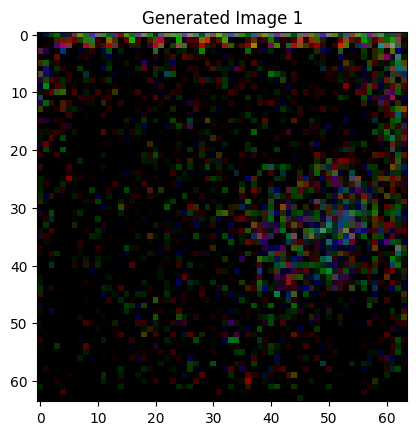

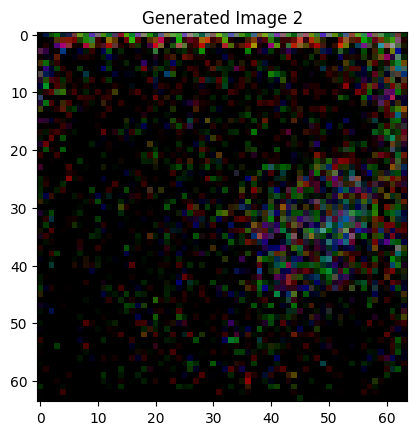

Test Loss: 1.0002, Test Accuracy: 0.6765


In [ ]:
import matplotlib.pyplot as plt

def load_generator_model(model_path, epoch, z_dim, text_dim):
    generator = Generator(z_dim, text_dim).to(device)
    generator.load_state_dict(torch.load('/content/generator_epoch_9.pth'))
    generator.eval()
    return generator

def generate_images(generator, text_encoder, captions, z_dim, device):
    # Encode the captions using the text encoder
    encoded_captions = []
    for caption in captions:
        inputs = tokenizer(caption, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        input_ids = inputs.input_ids.to(device)
        attention_mask = inputs.attention_mask.to(device)
        text_features = text_encoder(input_ids, attention_mask)
        encoded_captions.append(text_features)

    encoded_captions = torch.cat(encoded_captions, dim=0)

    # Generate random noise
    batch_size = len(captions)
    noise = torch.randn(batch_size, z_dim, device=device)

    # Generate images
    with torch.no_grad():
        generated_images = generator(noise, encoded_captions)

    return generated_images

def evaluate_discriminator(discriminator, test_loader, criterion, device):
    discriminator.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, _, _ in test_loader:
            images = images.to(device)
            labels = torch.ones(images.size(0), 1, device=device)  # Real images

            outputs = discriminator(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = outputs > 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy


# Paths
model_path = '/content'
epoch = 10  # Or the epoch you want to load

# Load models
generator = load_generator_model('/content/generator_epoch_9.pth', epoch, z_dim, text_dim)
discriminator = load_model('/content/discriminator_epoch_9.pth')

# Generate images from captions
captions = ["A child in a pink dress is climbing up a set of stairs in an entry way .", "A dog playing outside"]
generated_images = generate_images(generator, text_encoder, captions, z_dim, device)

# Save or display generated images
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Convert from CHW to HWC format
    plt.imshow(img.cpu().numpy())
    plt.title(f"Generated Image {i+1}")
    plt.show()

# Evaluate the discriminator
test_loss, test_acc = evaluate_discriminator(discriminator, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


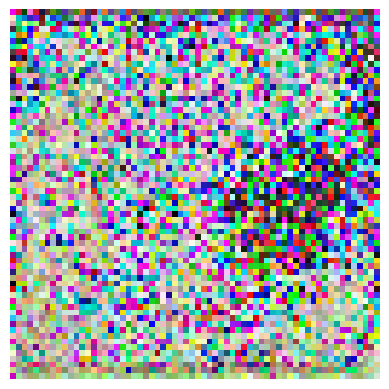

In [ ]:
def load_generator(model_path, z_dim, text_dim):
    generator = Generator(z_dim, text_dim)
    generator.load_state_dict(torch.load(model_path))
    generator.eval()
    return generator


def generate_image(generator, text_encoder, caption, z_dim, device):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    inputs = tokenizer(caption, return_tensors='pt', padding=True, truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    text_features = text_encoder(input_ids, attention_mask).to(device)
    noise = torch.randn(1, z_dim, device=device)

    with torch.no_grad():
        fake_image = generator(noise, text_features).cpu().detach()
    return fake_image

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_dim = 768
z_dim = 100

# Initialize text encoder
text_encoder = TextEncoder().to(device)

# Load the saved generator model
generator_path = '/content/generator_epoch_9.pth'  # Replace with your actual model path
generator = load_generator(generator_path, z_dim, text_dim).to(device)

# Example caption
caption = "A child in a pink dress is climbing up a set of stairs in an entry way ."

# Generate an image
fake_image = generate_image(generator, text_encoder, caption, z_dim, device)

# Convert the generated image to a format suitable for visualization
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

to_pil_image = ToPILImage()
image = to_pil_image(fake_image.squeeze())

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()